In [ ]:
"""
Baseline models with dataset of 1022 frames
Best performance: Random forests (AUC .75)
Examined bad photos that are predicted to be good

"""

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

## Load data and create df

In [68]:
blur = pd.read_pickle('./dump/blur_df')
face_info = pd.read_pickle('./dump/face_info_df')

In [69]:
df = pd.concat([blur.iloc[:,:-1],face_info.iloc[:,1:]],axis=1)
df

filename     lp_cat      lp_all  lp_ratio  blur  size_ratio  \
0     bad_0000.jpg   0.000000   22.753444  0.000000     1    0.000001   
1     bad_0001.jpg   4.660371  151.710709  0.030719     0    0.065138   
2     bad_0002.jpg  82.495362  124.841606  0.660800     0    0.091674   
3     bad_0003.jpg   2.091063   40.310794  0.051874     0    0.034277   
4     bad_0004.jpg   6.651127   97.543566  0.068186     0    0.074863   
..             ...        ...         ...       ...   ...         ...   
425  good_0425.jpg   2.431048   46.512277  0.052267     0    0.040754   
426  good_0426.jpg   3.087013   94.492551  0.032669     0    0.041603   
427  good_0427.jpg   1.495115   35.119939  0.042572     0    0.019353   
428  good_0428.jpg   1.342932   56.748645  0.023665     1    0.016823   
429  good_0429.jpg   1.021548   90.925883  0.011235     1    0.001406   

         to_ctr label  
0    739.595836   bad  
1     75.643903   bad  
2    517.827191   bad  
3    155.322246   bad  
4    467.641957   bad  
..          ...   ...  
425  155.801155  good  
426  368.228190  good  
427  144.585615  good  
428  154.159009  good  
429  810.405454  good  

[1022 rows x 8 columns]

In [70]:
# Train test split
X = df.iloc[:,:-1]

mapping = {'bad':0, 'good':1}
y = df['label'].map(mapping)

X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

In [71]:
# Reset index
X_train_df.reset_index(inplace=True,drop=True)
X_test_df.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

In [72]:
X_test_df

filename     lp_cat      lp_all  lp_ratio  blur  size_ratio  \
0    good_0400.jpg   6.678660   68.185890  0.097948     0    0.027317   
1     bad_0479.jpg   1.448002   41.623823  0.034788     0    0.022061   
2    good_0097.jpg   5.136785  174.606556  0.029419     1    0.070372   
3     bad_0031.jpg   8.349143  181.881367  0.045904     0    0.030625   
4    good_0025.jpg   4.742959  138.281020  0.034299     0    0.056875   
..             ...        ...         ...       ...   ...         ...   
200   bad_0452.jpg   1.332098   61.481349  0.021667     1    0.015234   
201  good_0125.jpg   2.900019  144.276161  0.020100     1    0.050105   
202  good_0333.jpg   2.785324  122.736748  0.022693     1    0.048710   
203   bad_0560.jpg  28.687493   58.173687  0.493135     0    0.091674   
204  good_0204.jpg   2.856067  101.163434  0.028232     1    0.015280   

         to_ctr  
0    440.164742  
1    177.282261  
2    461.781334  
3    341.716257  
4    322.262316  
..          ...  
200  133.899216  
201  283.746366  
202  309.181177  
203  585.103410  
204  425.882613  

[205 rows x 7 columns]

## Scale continuous variables

In [100]:
# Continuous variables
features = ['lp_cat', 'lp_all', 'lp_ratio', 'size_ratio', 'to_ctr']
X_train_con = X_train_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train_con_scaled = scaler.fit_transform(X_train_df[features])
cont_columns = X_train_con.columns
X_train_con_df = pd.DataFrame(X_train_con_scaled, columns=cont_columns, index=X_train_con.index)
# X_train_con_df

In [131]:
# Try without 'blur'
X_train = X_train_con_df

In [101]:
# Combine Con and Cat
X_train = pd.concat([X_train_df[['blur']],X_train_con_df], axis='columns')
X_train

blur    lp_cat    lp_all  lp_ratio  size_ratio    to_ctr
0       0 -0.232586 -0.735026 -0.192010    0.122065 -0.421185
1       1 -0.255792 -0.787508 -0.235555   -0.569909 -0.700983
2       0 -0.242751 -0.957512 -0.152219   -0.066723 -0.939454
3       1 -0.197967  0.605966 -0.263488    0.248174  0.275829
4       0 -0.194996 -0.582818 -0.151327    1.212259 -0.075042
..    ...       ...       ...       ...         ...       ...
812     1 -0.225143  0.669540 -0.284955   -0.165893 -1.047943
813     1 -0.234743 -0.429617 -0.241061    0.134395 -0.421905
814     0 -0.158899 -0.349438 -0.142205    0.394104 -0.156311
815     1 -0.235731 -0.451278 -0.240404    0.159242 -0.416492
816     0 -0.233644 -0.729094 -0.195633   -0.077992 -0.848626

[817 rows x 6 columns]

In [105]:
# Repeat for test set
# Continuous variables
features = ['lp_cat', 'lp_all', 'lp_ratio', 'size_ratio', 'to_ctr']
X_test_con = X_test_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_test_con_scaled = scaler.fit_transform(X_test_df[features])
cont_columns = X_test_con.columns
X_test_con_df = pd.DataFrame(X_test_con_scaled, columns=cont_columns, index=X_test_con.index)

# Combine Con and Cat
X_test = pd.concat([X_test_df[['blur']],X_test_con_df], axis='columns')
X_test

blur    lp_cat    lp_all  lp_ratio  size_ratio    to_ctr
0       0 -0.131002 -0.552437 -0.065390   -0.356462  0.493127
1       0 -0.255695 -0.923366 -0.238188   -0.496533 -0.981655
2       1 -0.167758  0.933685 -0.252875    0.791046  0.614397
3       0 -0.091180  1.035275 -0.207774   -0.268291 -0.059173
4       0 -0.177147  0.426413 -0.239524    0.431320 -0.168311
..    ...       ...       ...       ...         ...       ...
200     1 -0.258458 -0.646063 -0.274085   -0.678487 -1.225035
201     1 -0.221080  0.510133 -0.278370    0.250881 -0.384387
202     1 -0.223814  0.209344 -0.271276    0.213703 -0.241696
203     0  0.393662 -0.692254  1.015789    1.358785  1.306239
204     1 -0.222128 -0.091919 -0.256123   -0.677271  0.413003

[205 rows x 6 columns]

In [132]:
# Try without 'blur'
X_test = X_test_con_df

## 1. Logistic regression

In [133]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
print('intercept: ', round(lm.intercept_[0], 4))
pd.DataFrame(list(zip(X_train.columns,np.transpose(lm.coef_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)

intercept:  -0.3236


Feature                     Coef
3  size_ratio     [0.5081449288366844]
0      lp_cat      [0.489400612992255]
4      to_ctr     [0.1544058831892723]
1      lp_all  [-0.009764776367614606]
2    lp_ratio    [-0.9436832333753161]

In [134]:
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-Bad (0)','Predict-Good (1)'],\
            index=['Bad (0)','Good (1)'])

Predict-Bad (0)  Predict-Good (1)
Bad (0)               106                14
Good (1)               67                18

In [135]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion/np.sum(fraud_confusion), cmap=plt.cm.Blues,
           annot=True, square=True, fmt='.2%',
           xticklabels=['Bad', 'Good'],
           yticklabels=['Bad', 'Good']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [136]:
from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [137]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.6048780487804878 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.61      0.88      0.72       120
           1       0.56      0.21      0.31        85

    accuracy                           0.60       205
   macro avg       0.59      0.55      0.52       205
weighted avg       0.59      0.60      0.55       205



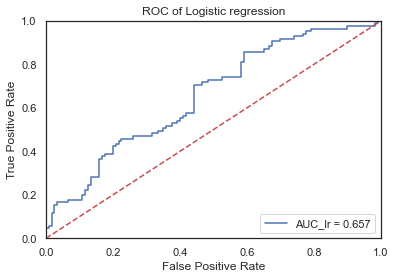

In [138]:
# Logistic regression ROC curve
y_scores = lm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_lr = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of Logistic regression')
plt.show()

## 2. KNN 

In [139]:
from sklearn.neighbors import KNeighborsClassifier

knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train,y_train)
pred = knn_3.predict(X_test)

print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (kNN, n=3):\n\n',classification_report(y_test,pred))

Accuracy score: 0.6926829268292682 

Classification report (kNN, n=3):

               precision    recall  f1-score   support

           0       0.72      0.77      0.74       120
           1       0.64      0.59      0.61        85

    accuracy                           0.69       205
   macro avg       0.68      0.68      0.68       205
weighted avg       0.69      0.69      0.69       205



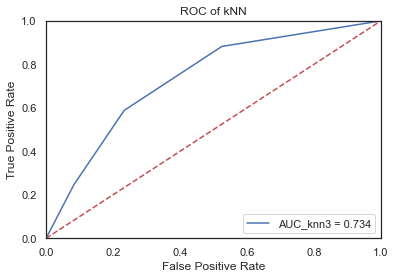

In [140]:
# knn=3 ROC curve
y_scores = knn_3.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'AUC_knn3 = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of kNN')
plt.show()

## 3. Naive Bayes

In [141]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train,y_train)
pred = nb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Naive Bayes):\n\n',classification_report(y_test,pred))

Accuracy score: 0.6292682926829268 

Classification report (Naive Bayes):

               precision    recall  f1-score   support

           0       0.69      0.67      0.68       120
           1       0.55      0.58      0.56        85

    accuracy                           0.63       205
   macro avg       0.62      0.62      0.62       205
weighted avg       0.63      0.63      0.63       205



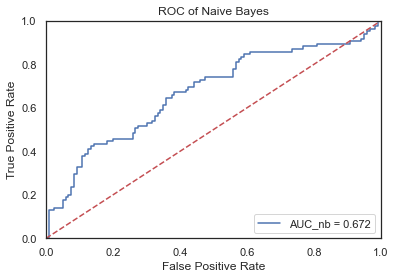

In [142]:
# Naive Bayes ROC curve
y_scores = nb.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_nb = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of Naive Bayes')
plt.show()

## 4. Decision tree - classification

In [143]:
def quick_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

def quick_test_afew_times(model, X_train, y_train, X_test, y_test, n=10):
    return np.mean([quick_test(model, X_train, y_train, X_test, y_test) for j in range(n)])

In [144]:
from sklearn.svm import LinearSVC
# Linear SVC
linearsvc = LinearSVC()

# Do the test 10 times with a LinearSVC and get the average score
quick_test_afew_times(linearsvc, X_train, y_train, X_test, y_test)

/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976

0.5960975609756096

In [145]:
from sklearn.tree import DecisionTreeClassifier
# Decision tree
decisiontree = DecisionTreeClassifier(max_depth=4)
quick_test_afew_times(decisiontree, X_train, y_train, X_test, y_test)

0.6585365853658536

In [146]:
pred = decisiontree.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Decision Tree):\n\n',classification_report(y_test,pred))

Accuracy score: 0.6585365853658537 

Classification report (Decision Tree):

               precision    recall  f1-score   support

           0       0.66      0.88      0.75       120
           1       0.67      0.35      0.46        85

    accuracy                           0.66       205
   macro avg       0.66      0.61      0.61       205
weighted avg       0.66      0.66      0.63       205



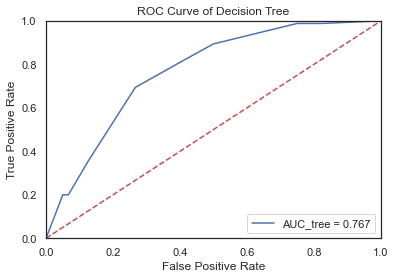

In [147]:
# Decision Tree ROC curve
y_scores = decisiontree.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_tree = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Decision Tree')
plt.show()

## 5. Random Forests

In [148]:
from sklearn.ensemble import RandomForestClassifier
# Random Forests
randomforest = RandomForestClassifier(n_estimators=100)
quick_test_afew_times(randomforest, X_train, y_train, X_test, y_test)

0.7165853658536585

In [149]:
pred = randomforest.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Random Forests):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7463414634146341 

Classification report (Random Forests):

               precision    recall  f1-score   support

           0       0.74      0.87      0.80       120
           1       0.75      0.58      0.65        85

    accuracy                           0.75       205
   macro avg       0.75      0.72      0.73       205
weighted avg       0.75      0.75      0.74       205



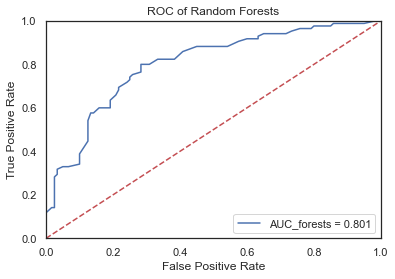

In [150]:
# Random Forests ROC curve
y_scores = randomforest.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_forests = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of Random Forests')
plt.show()

In [151]:
interactive(lambda threshold: make_confusion_matrix(randomforest, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [152]:
# y_scores

## Examine the results
Check false positive images

In [153]:
test_df = X_test_df.merge(y_test,left_index=True, right_index=True)

In [154]:
model = randomforest
threshold = 0.46
y_predict = (model.predict_proba(X_test)[:, 1] >= threshold).tolist()
test_df['pred'] = [0 if x==False else 1 for x in y_predict ]
test_df

filename     lp_cat      lp_all  lp_ratio  blur  size_ratio  \
0    good_0400.jpg   6.678660   68.185890  0.097948     0    0.027317   
1     bad_0479.jpg   1.448002   41.623823  0.034788     0    0.022061   
2    good_0097.jpg   5.136785  174.606556  0.029419     1    0.070372   
3     bad_0031.jpg   8.349143  181.881367  0.045904     0    0.030625   
4    good_0025.jpg   4.742959  138.281020  0.034299     0    0.056875   
..             ...        ...         ...       ...   ...         ...   
200   bad_0452.jpg   1.332098   61.481349  0.021667     1    0.015234   
201  good_0125.jpg   2.900019  144.276161  0.020100     1    0.050105   
202  good_0333.jpg   2.785324  122.736748  0.022693     1    0.048710   
203   bad_0560.jpg  28.687493   58.173687  0.493135     0    0.091674   
204  good_0204.jpg   2.856067  101.163434  0.028232     1    0.015280   

         to_ctr  label  pred  
0    440.164742      1     0  
1    177.282261      0     0  
2    461.781334      1     0  
3    341.716257      0     1  
4    322.262316      1     1  
..          ...    ...   ...  
200  133.899216      0     0  
201  283.746366      1     1  
202  309.181177      1     1  
203  585.103410      0     0  
204  425.882613      1     1  

[205 rows x 9 columns]

In [155]:
# False-positive: bad photos but predicted to be good
FP = test_df[(test_df.label==0) & (test_df.pred==1)]
FP_img = FP.filename.tolist()
FP_len = len(FP_img)
FP_len

25

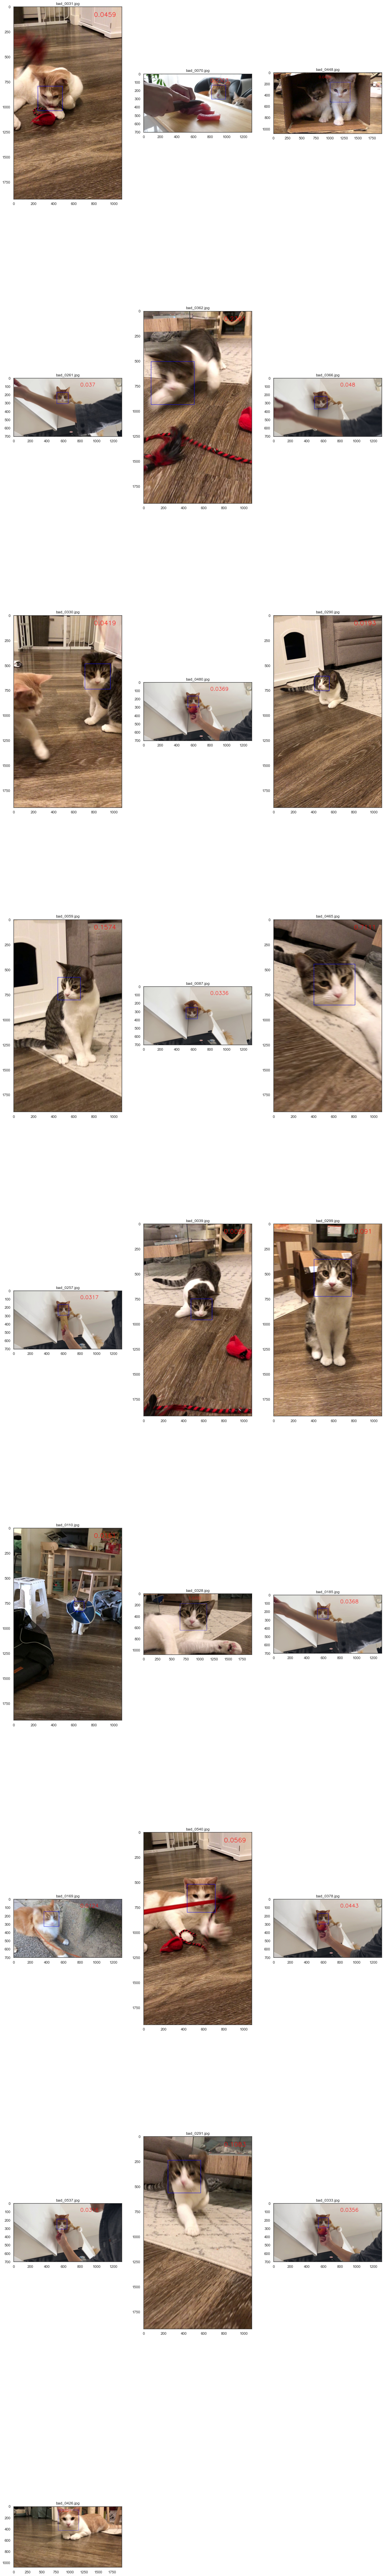

In [156]:
import cv2 as cv

# Text parameters 
font = cv.FONT_HERSHEY_SIMPLEX
org = (800, 100)
fontScale = 2
color = (255, 0, 0)
thickness = 2

# List of lp_ratio
lp_ratios = [round(x,4) for x in FP.lp_ratio.tolist()]

# Plots
fig, axs = plt.subplots(figsize=(20, 150))
for i, filename in enumerate(FP_img[:]):
    img = cv.imread('OpenCV_blur/frame_bad_rename/'+filename)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    # Annotate lp_ratio
    lp_ratio = str(lp_ratios[i])
    rgb = cv.putText(rgb, lp_ratio,org, font,  
                   fontScale, color, thickness, cv.LINE_AA) 
    plt.subplot(FP_len//3+1,3,i+1)
    plt.imshow(rgb)
    plt.title(filename)

plt.show()